In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import seaborn as sns

from sklearn import metrics
from random import randint
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

# from __future__ import division
import math
import itertools
import warnings
warnings.filterwarnings("ignore")

import env

Use DBSCAN to detect anomalies in other products from the customers dataset.

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'
    
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
# df.drop(["Channel", "Fresh"], axis = 1, inplace = True)
df = df[["Fresh", "Delicassen","Frozen"]]
df.head()

,Fresh,Delicassen,Frozen
customer_id,,,
0,12669,1338,214
1,7057,1776,1762
2,6353,7844,2405
3,13265,1788,6404
4,22615,5185,3915


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Fresh       440 non-null    int64
 1   Delicassen  440 non-null    int64
 2   Frozen      440 non-null    int64
dtypes: int64(3)
memory usage: 13.8 KB


In [5]:
np_array = df.values.astype("int64", copy = False)
np_array[0:10]

array([[12669,  1338,   214],
       [ 7057,  1776,  1762],
       [ 6353,  7844,  2405],
       [13265,  1788,  6404],
       [22615,  5185,  3915],
       [ 9413,  1451,   666],
       [12126,   545,   480],
       [ 7579,  2566,  1669],
       [ 5963,   750,   425],
       [ 6006,  2098,  1159]])

In [6]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.11294004, 0.02784731, 0.0031063 ],
       [0.06289903, 0.03698373, 0.02854842],
       [0.05662161, 0.16355861, 0.03911643],
       [0.11825445, 0.03723404, 0.10484189],
       [0.20162642, 0.10809345, 0.063934  ],
       [0.08390698, 0.03020442, 0.01053514],
       [0.10809823, 0.0113058 , 0.00747814],
       [0.06755359, 0.05346266, 0.02701992],
       [0.05314406, 0.01558198, 0.00657419],
       [0.05352748, 0.04370046, 0.01863783]])

In [7]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 40)
# fit the object
dbsc.fit(np_array)

DBSCAN(eps=0.1, min_samples=40)

In [8]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [9]:
df.head()

,Fresh,Delicassen,Frozen,Scaled_Fresh,Scaled_Delicassen,Scaled_Frozen
0,12669,1338,214,0.112940,0.027847,0.003106
1,7057,1776,1762,0.062899,0.036984,0.028548
2,6353,7844,2405,0.056622,0.163559,0.039116
3,13265,1788,6404,0.118254,0.037234,0.104842
4,22615,5185,3915,0.201626,0.108093,0.063934


In [10]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
# assign the cluster labels
# recall the cluster labels dont have inherent meaning
# DBSCAN makes a cluster called -1 that contatins the noise or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()
# by changing the epsilon you change the number or noise/outliers

 0    413
-1     27
Name: labels, dtype: int64

In [12]:
df[df.labels==-1].head()

,Fresh,Delicassen,Frozen,Scaled_Fresh,Scaled_Delicassen,Scaled_Frozen,labels
23,26373,16523,5154,0.235136,0.344597,0.084298,-1
29,43088,823,1200,0.384180,0.017105,0.019312,-1
39,56159,2916,10002,0.500731,0.060763,0.163977,-1
47,44466,6465,7782,0.396467,0.134793,0.127490,-1
71,18291,14472,5373,0.163070,0.301815,0.087897,-1


In [13]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
               Fresh    Delicassen        Frozen  Scaled_Fresh  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   1524.870455   3071.931818      0.106977   
std     12647.328865   2820.105937   4854.673333      0.112774   
min         3.000000      3.000000     25.000000      0.000000   
25%      3127.750000    408.250000    742.250000      0.027863   
50%      8504.000000    965.500000   1526.000000      0.075802   
75%     16933.750000   1820.250000   3554.250000      0.150968   
max    112151.000000  47943.000000  60869.000000      1.000000   

       Scaled_Delicassen  Scaled_Frozen      labels  
count         440.000000     440.000000  440.000000  
mean            0.031745       0.050078   -0.061364  
std             0.058826       0.079789    0.240269  
min             0.000000       0.000000   -1.000000  
25%             0.008453       0.011788    0.000000  
50%             0.020077       0.024670    0.000000  
75%             

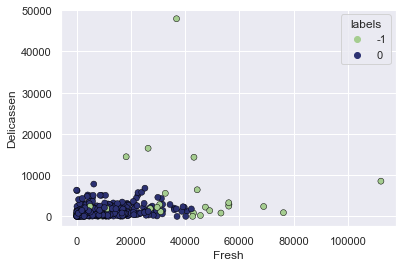

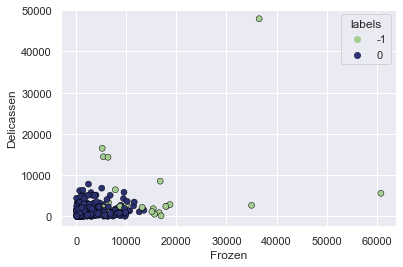

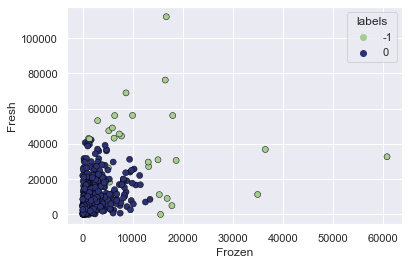

In [14]:
sns.set(style="darkgrid")
sns.scatterplot(df.Fresh, df.Delicassen, hue=df.labels, palette='crest', ec='black')
plt.show()

sns.scatterplot(df.Frozen, df.Delicassen, hue=df.labels, palette='crest', ec='black')
plt.show()

sns.scatterplot(df.Frozen, df.Fresh, hue=df.labels, palette='crest', ec='black')
plt.show()

Text(0.5, 0, 'Frozen')

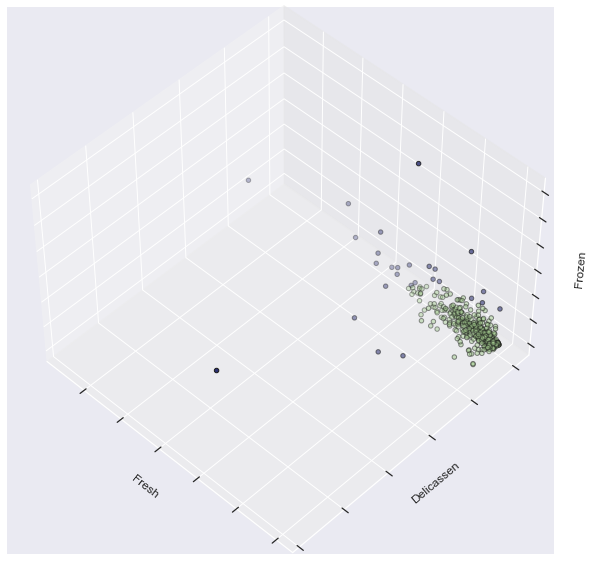

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Delicassen, df.Frozen,
           c=df.labels, edgecolor='k', cmap='crest_r')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Delicassen')
ax.set_zlabel('Frozen')

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [52]:
df = pd.read_csv('zillow.csv')
df.index = df['Unnamed: 0']
df = df.rename(columns={'Unnamed: 0':'index'})
df = df.drop(columns=['index'], axis=1)
df.head()

,bedrooms,square_feet
Unnamed: 0,,
0,4.0,3100.0
1,2.0,1465.0
2,3.0,1243.0
3,4.0,2376.0
4,3.0,1312.0


In [53]:
np_array = df.values.astype("float64", copy = False)
np_array[0:10]

array([[4.000e+00, 3.100e+03],
       [2.000e+00, 1.465e+03],
       [3.000e+00, 1.243e+03],
       [4.000e+00, 2.376e+03],
       [3.000e+00, 1.312e+03],
       [3.000e+00, 1.492e+03],
       [4.000e+00, 2.962e+03],
       [2.000e+00, 7.380e+02],
       [4.000e+00, 3.039e+03],
       [2.000e+00, 1.290e+03]])

In [54]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.28571429, 0.13632402],
       [0.14285714, 0.06132746],
       [0.21428571, 0.05114444],
       [0.28571429, 0.10311454],
       [0.21428571, 0.05430944],
       [0.21428571, 0.06256594],
       [0.28571429, 0.12999404],
       [0.14285714, 0.02798037],
       [0.28571429, 0.13352599],
       [0.14285714, 0.05330031]])

In [55]:
# Make the object
dbsc = DBSCAN(eps = .07, min_samples = 3000)

In [56]:
# fit the object
dbsc.fit(np_array)

DBSCAN(eps=0.07, min_samples=3000)

In [57]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [58]:
# Save a copy of the original dataframe
original_df = df.copy()

In [59]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array)

In [60]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df = df.rename(columns={0:'Scaled_bathrooms',1:'Scaled_square_feet'})

In [61]:
df.head()

,bedrooms,square_feet,Scaled_bathrooms,Scaled_square_feet
0,4.0,3100.0,0.285714,0.136324
1,2.0,1465.0,0.142857,0.061327
2,3.0,1243.0,0.214286,0.051144
3,4.0,2376.0,0.285714,0.103115
4,3.0,1312.0,0.214286,0.054309


In [62]:
labels = dbsc.labels_
labels[0:10]

array([0, 1, 2, 0, 2, 2, 0, 1, 0, 1])

In [63]:
df['labels'] = dbsc.labels_
df.labels.value_counts()

 2    29058
 1    18576
 0    15935
 3     3715
 4     3331
-1     1435
Name: labels, dtype: int64

In [64]:
df[df.labels==-1].head()

,bedrooms,square_feet,Scaled_bathrooms,Scaled_square_feet,labels
25,6.0,3870.0,0.428571,0.171644,-1
57,0.0,440.0,0.000000,0.014311,-1
63,5.0,9586.0,0.357143,0.433833,-1
71,5.0,5900.0,0.357143,0.264758,-1
72,5.0,5823.0,0.357143,0.261227,-1


In [65]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
           bedrooms   square_feet  Scaled_bathrooms  Scaled_square_feet  \
count  72050.000000  72050.000000      72050.000000        72050.000000   
mean       3.006149   1750.261777          0.214725            0.074412   
std        1.023576    933.071834          0.073113            0.042799   
min        0.000000    128.000000          0.000000            0.000000   
25%        2.000000   1164.000000          0.142857            0.047521   
50%        3.000000   1510.000000          0.214286            0.063392   
75%        4.000000   2063.000000          0.285714            0.088757   
max       14.000000  21929.000000          1.000000            1.000000   

             labels  
count  72050.000000  
mean       1.384122  
std        1.085787  
min       -1.000000  
25%        1.000000  
50%        2.000000  
75%        2.000000  
max        4.000000  
-------------
Inliers
       bedrooms   square_feet  Scaled_bathrooms  Scaled_square_feet   labels
count   15935.0 

In [ ]:
sns.countplot(df.labels, palette='crest', ec='black')

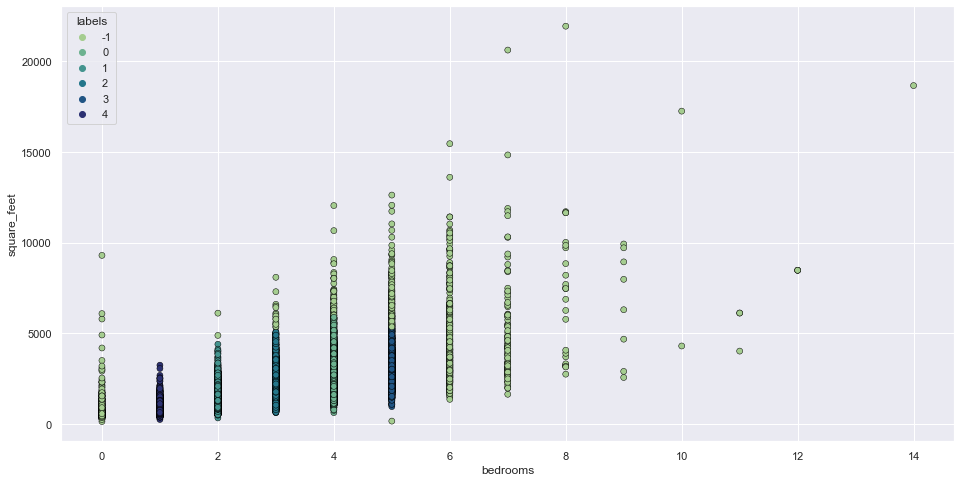

In [30]:
plt.figure(figsize=(16,8))
sns.scatterplot(df.bedrooms, df.square_feet, hue=df.labels, palette='crest', ec='black')
plt.show()


Use DBSCAN to detect anomalies in numberin the log assessed dataset.

In [31]:
df = pd.read_csv('log_access.csv')
df.head()

,Unnamed: 0,webpage_accessed,user_id,cohort_id,ip_address,cohort_name,start_date,end_date,program_id,program_type,month,month_name,year,weekday
0,2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,PHP,1,January,2018,Friday
1,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,PHP,1,January,2018,Friday
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,PHP,1,January,2018,Friday
3,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,PHP,1,January,2018,Friday
4,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2,Java,1,January,2018,Friday


#### Cluster Everything

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847329 entries, 0 to 847328
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        847329 non-null  object 
 1   webpage_accessed  847329 non-null  object 
 2   user_id           847329 non-null  int64  
 3   cohort_id         847329 non-null  float64
 4   ip_address        847329 non-null  object 
 5   cohort_name       847329 non-null  object 
 6   start_date        847329 non-null  object 
 7   end_date          847329 non-null  object 
 8   program_id        847329 non-null  int64  
 9   program_type      847329 non-null  object 
 10  month             847329 non-null  int64  
 11  month_name        847329 non-null  object 
 12  year              847329 non-null  int64  
 13  weekday           847329 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 90.5+ MB


In [33]:
df.user_id.value_counts()

11     17913
64     16322
53     12329
314     7783
1       7404
       ...  
952        1
649        1
940        1
163        1
652        1
Name: user_id, Length: 911, dtype: int64

In [34]:
scale_columns = ['user_id', 'cohort_id', 'program_id', 
                     'year', 'month']

In [35]:
scaler = MinMaxScaler()

In [36]:
scaler.fit(df[scale_columns])

MinMaxScaler()

In [37]:
scaled = scaler.transform(df[scale_columns])

In [38]:
scaled = pd.DataFrame(scaled)
scaled.head()

,0,1,2,3,4
0,0.00000,0.050725,0.000000,0.0,0.0
1,0.00000,0.050725,0.000000,0.0,0.0
2,0.00000,0.050725,0.000000,0.0,0.0
3,0.00000,0.050725,0.000000,0.0,0.0
4,0.00102,0.152174,0.333333,0.0,0.0


In [39]:
scaled = scaled.rename(columns={0:'user_id', 1:'cohort_id', 
                        2:'program_id', 3:'year', 4:'month'})
scaled.head()

,user_id,cohort_id,program_id,year,month
0,0.00000,0.050725,0.000000,0.0,0.0
1,0.00000,0.050725,0.000000,0.0,0.0
2,0.00000,0.050725,0.000000,0.0,0.0
3,0.00000,0.050725,0.000000,0.0,0.0
4,0.00102,0.152174,0.333333,0.0,0.0


In [40]:
# Make the object
dbsc = DBSCAN(eps = .04, min_samples = 2000)

In [41]:
# fit the object
dbsc.fit(scaled)

DBSCAN(eps=0.04, min_samples=2000)

In [42]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [43]:
# Save a copy of the original dataframe
original_df = df.copy()

In [44]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array)
                

In [46]:
df.head()

,Unnamed: 0,webpage_accessed,user_id,cohort_id,ip_address,cohort_name,start_date,end_date,program_id,program_type,month,month_name,year,weekday
0,2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,PHP,1,January,2018,Friday
1,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,PHP,1,January,2018,Friday
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,PHP,1,January,2018,Friday
3,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,PHP,1,January,2018,Friday
4,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2,Java,1,January,2018,Friday


In [48]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
#df = df.rename(columns={0:'Scaled_bathrooms',1:'Scaled_square_feet'})

KeyError: RangeIndex(start=0, stop=847329, step=1)

## Cluster Specific Features